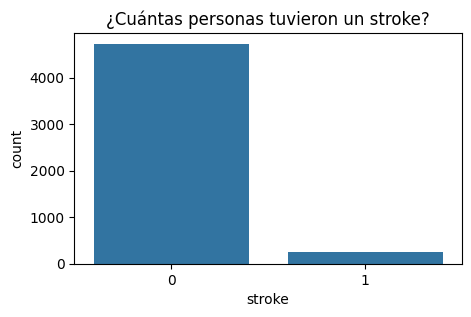

Proporción de personas con y sin stroke:
stroke
0    0.950211
1    0.049789
Name: proportion, dtype: float64

Valores nulos explícitos por columna:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Total de valores nulos explícitos: 0
Valores únicos de 'gender': [0 1]
Archivo exportado a ../data/processed/preprocessing2.csv


In [11]:
# ==========================================================
# PREPROCESAMIENTO SIN DIVISIÓN TRAIN/TEST NI SMOTE
# ==========================================================

# PASO 1: Cargar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# PASO 2: Cargar el dataset 
df = pd.read_csv('../data/raw/stroke_dataset.csv')

# PASO 3: Visualizar y analizar la variable objetivo (stroke)
plt.figure(figsize=(5,3))
sns.countplot(x='stroke', data=df)
plt.title('¿Cuántas personas tuvieron un stroke?')
plt.show()
print('Proporción de personas con y sin stroke:')
print(df['stroke'].value_counts(normalize=True))

# PASO 4: Comprobar si hay datos faltantes (nulos)
print("\nValores nulos explícitos por columna:")
print(df.isnull().sum())
print(f"Total de valores nulos explícitos: {df.isnull().sum().sum()}")

# PASO 5: Transformar variables categóricas a números
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].map({'Urban': 0, 'Rural': 1})

# Forzar todas las categorías posibles en work_type y smoking_status
work_type_cats = ['children', 'Govt_job', 'Never_worked', 'Private', 'Self-employed']
smoking_status_cats = ['formerly smoked', 'never smoked', 'smokes', 'Unknown']

df['work_type'] = pd.Categorical(df['work_type'], categories=work_type_cats)
df['smoking_status'] = pd.Categorical(df['smoking_status'], categories=smoking_status_cats)

df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=False)
print("Valores únicos de 'gender':", df['gender'].unique())

# PASO 6: Aplicar logaritmo a avg_glucose_level para reducir el efecto de valores extremos
df['avg_glucose_level_log'] = np.log1p(df['avg_glucose_level'])

# PASO 7: Definir columnas numéricas y categóricas finales
num_cols = ['age', 'avg_glucose_level_log', 'bmi']
bin_cat_cols = ['hypertension', 'heart_disease', 'gender', 'ever_married', 'Residence_type']
cat_cols = [col for col in df.columns if col.startswith('work_type_') or col.startswith('smoking_status_')]

# PASO 8: Concatenar variables numéricas y categóricas
X = df[num_cols + bin_cat_cols + cat_cols]
y = df['stroke']

# PASO 9: Estandarizar SOLO las columnas numéricas continuas en todo el dataset
scaler = StandardScaler()
X_std = X.copy()
X_std[num_cols] = scaler.fit_transform(X[num_cols])

# Concatenar la variable objetivo para exportar
df_final = X_std.copy()
df_final['stroke'] = y

# PASO 10: Exportar el archivo a la carpeta processed
df_final.to_csv('../data/processed/preprocessing.csv', index=False)
print("Archivo exportado a ../data/processed/preprocessing2.csv")

In [12]:
# Cargar ambos datasets
df_original = pd.read_csv('../data/raw/stroke_dataset.csv')
df_processed = pd.read_csv('../data/processed/preprocessing.csv')

print("✅ Datasets cargados correctamente")
print(f"Original: {df_original.shape}")
print(f"Procesado: {df_processed.shape}")

# PASO 1: Recrear las transformaciones exactas del preprocessing
print("\n🔄 Recreando transformaciones...")

# Aplicar log1p a glucosa (igual que en el preprocessing)
df_original['avg_glucose_level_log'] = np.log1p(df_original['avg_glucose_level'])

# PASO 2: Extraer las columnas numéricas ANTES del escalado
num_cols_original = ['age', 'avg_glucose_level_log', 'bmi']
X_numeric_original = df_original[num_cols_original]

print("Estadísticas de las variables ANTES del escalado:")
print(X_numeric_original.describe())

# PASO 3: Crear y entrenar el StandardScaler con los datos originales
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_original)

print("\n📊 Parámetros del StandardScaler recreado:")
print("Medias (mean_):", scaler.mean_)
print("Desviaciones estándar (scale_):", scaler.scale_)

# PASO 4: Verificar que coincide con los datos procesados
# Extraer las mismas columnas del dataset procesado
X_numeric_processed = df_processed[num_cols_original]

print("\n🔍 Verificación - Primeras 5 filas:")
print("Datos escalados recreados:")
print(pd.DataFrame(X_numeric_scaled[:5], columns=num_cols_original))
print("\nDatos del preprocessing2.csv:")
print(X_numeric_processed.head())

# PASO 5: Verificar que son idénticos (diferencia máxima)
difference = np.abs(X_numeric_scaled - X_numeric_processed.values)
max_diff = np.max(difference)
print(f"\n✅ Diferencia máxima entre escalados: {max_diff:.10f}")

if max_diff < 1e-10:
    print("🎯 ¡PERFECTO! El scaler recreado es idéntico al original")
else:
    print("⚠️ Hay diferencias. Revisar transformaciones.")

# PASO 6: Guardar el scaler recreado
import os
os.makedirs('../models', exist_ok=True)

with open('../models/scaler_recreated.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"\n💾 Scaler guardado en: ../models/scaler_recreated.pkl")

# PASO 7: Test del scaler recreado
print("\n🧪 Test del scaler recreado:")
test_data = np.array([[65, np.log1p(180), 28.5]])  # edad=65, glucosa=180, bmi=28.5
test_scaled = scaler.transform(test_data)
print(f"Datos test originales: {test_data[0]}")
print(f"Datos test escalados: {test_scaled[0]}")

# PASO 8: Función para usar en el pipeline
def load_scaler():
    """Carga el scaler recreado"""
    with open('../models/scaler_recreated.pkl', 'rb') as f:
        return pickle.load(f)

print("\n✅ ¡Scaler recreado exitosamente!")
print("Ahora puedes usar load_scaler() en tu pipeline de producción")

✅ Datasets cargados correctamente
Original: (4981, 11)
Procesado: (4981, 18)

🔄 Recreando transformaciones...
Estadísticas de las variables ANTES del escalado:
               age  avg_glucose_level_log          bmi
count  4981.000000            4981.000000  4981.000000
mean     43.419859               4.601758    28.498173
std      22.662755               0.357280     6.790464
min       0.080000               4.027492    14.000000
25%      25.000000               4.359653    23.700000
50%      45.000000               4.530985    28.100000
75%      61.000000               4.743714    32.600000
max      82.000000               5.608519    48.900000

📊 Parámetros del StandardScaler recreado:
Medias (mean_): [43.41985947  4.60175769 28.49817306]
Desviaciones estándar (scale_): [22.66048004  0.35724456  6.78978196]

🔍 Verificación - Primeras 5 filas:
Datos escalados recreados:
        age  avg_glucose_level_log       bmi
0  1.040584               2.337259  1.193238
1  1.614270              

/Users/pepe/Documents/IA_FactoriaF5/data_scientist_g3/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
